# Graph quality evaluation
In this notebook, we'll undertake some qualitative and quantitative approaches to evaluating the quality of the various graph generation approaches we've used.

For the sake of this notebooks, "graph quality" refers to the underlying performance of the entity and relation extraction pipelines that are used to build the graph. This decision is based on the assumption that a "gold standard" graph, when built from unstructured scientific articles, is a graph where relations and entities were perfectly extracted from the original source.

In [65]:
import jsonlines
from collections import defaultdict
import matplotlib.pyplot as plt
plt.rcParams['pdf.fonttype'] = 42
import networkx as nx
from math import comb
from statistics import median
import json
import pandas as pd
from tqdm import tqdm
from os import listdir
from os.path import splitext
import yaml
import spacy
from spacy import displacy

/mnt/home/lotrecks/anaconda3/envs/graphs/lib/python3.10/site-packages/torch/cuda/__init__.py:138: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11040). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0
2024-05-23 19:36:13.268148: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-23 19:36:48.986184: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dr

## Use PICKLE dataset as a baseline quantitative metric
While we don't have a gold standard of entities and relations for our drought/desiccation dataset, we do have access to the [PICKLE dataset](https://huggingface.co/datasets/slotreck/pickle), which has a gold-standard set of entities and relations labeled on 250 plant science abstracts. We'll use the PICKLE dataset to set an expectation for what quantity and ratio of entities and relations we think we should see in our larger drought/desiccation corpus. If our graphs fall far short of the kind of relation/entity ratio that we see in PICKLE, we can say that likely, the recall of the method(s) is poor.

To provide more compelling evidence that PICKLE is a reasonable comparison to our drought/desiccation dataset, we'll also do some comparisons of more basic statistics like abstract length, average word length, and average sentence length.

In [2]:
with jsonlines.open('../data/pickle/pickle_all.jsonl') as reader:
    pickle = [obj for obj in reader]

In [3]:
with jsonlines.open('../data/dygiepp/model_predictions/09Apr24_dygiepp_test_formatted_data_pickle_predictions.jsonl') as reader:
    drought_des = [obj for obj in reader]

In [4]:
datasets = {
    'PICKLE': pickle,
    'drought + desiccation': drought_des
}

### Basic dataset comparisons

In [5]:
abstract_lens = defaultdict(list)
sent_lens = defaultdict(list)
word_lens = defaultdict(list)
for dset_name, dataset in datasets.items():
    for doc in dataset:
        abstract_lens[dset_name].append(len(doc['sentences']))
        for sent in doc['sentences']:
            sent_lens[dset_name].append(len(sent))
            for tok in sent:
                word_lens[dset_name].append(len(tok))
basic_stats = {
    'sentences per abstract': abstract_lens,
    'words per sentence': sent_lens,
    'letters per word': word_lens
}

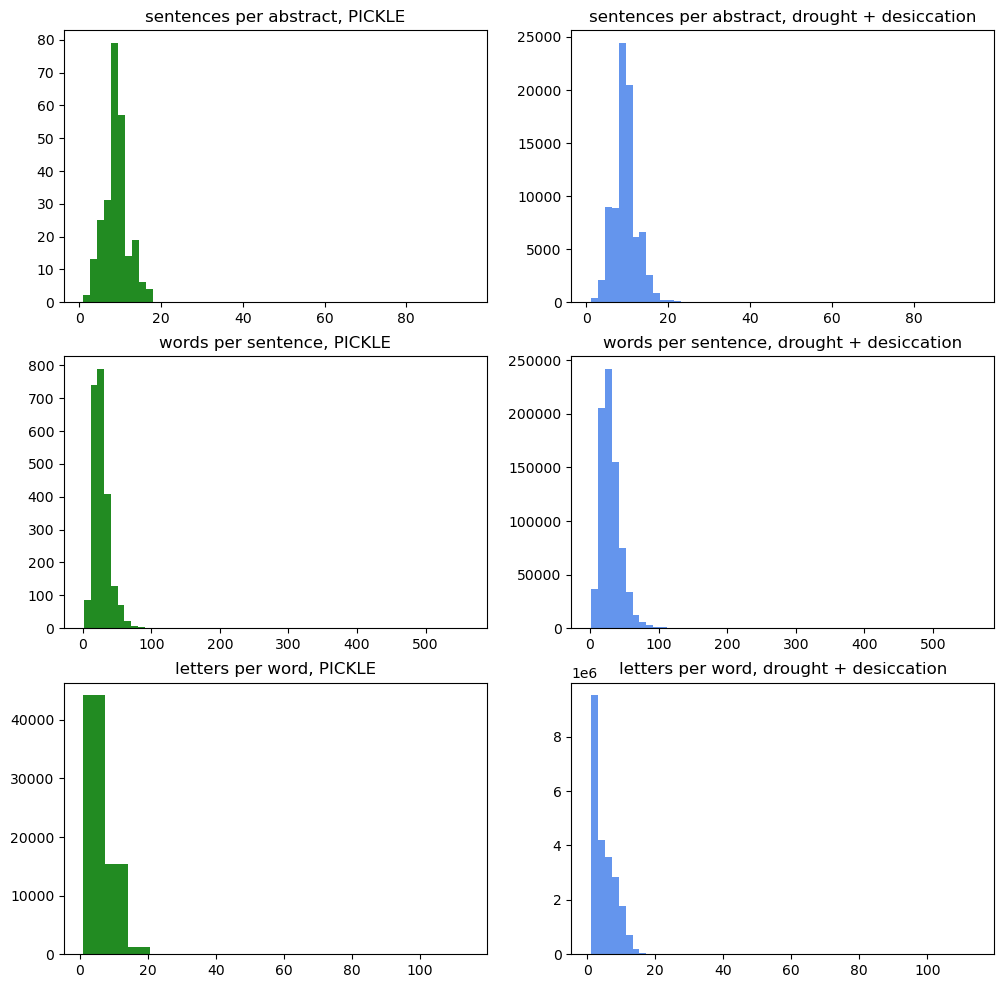

In [6]:
fig, axs = plt.subplots(3, 2, figsize=(12,12), sharex='row')
colors = {'PICKLE': 'forestgreen', 'drought + desiccation': 'cornflowerblue'}
for stat, axz in zip(basic_stats, axs):
    for dset_name, ax in zip(basic_stats[stat], axz):
        vals = basic_stats[stat][dset_name]
        if dset_name == 'PICKLE':
            _, bins, _ = ax.hist(vals, label=dset_name, color=colors[dset_name])
        elif dset_name == 'drought + desiccation':
            ax.hist(vals, bins=len(bins)*5, label=dset_name, color=colors[dset_name])
        ax.set_title(f'{stat}, {dset_name}')
plt.savefig('../data/figures/basic_dataset_statistics_comparison_pickle.pdf', format='pdf',
           bbox_inches='tight', dpi=600)

Figure caption: Histograms of basic dataset statistics for the PICKLE and drought/desiccation dataset. X-limits for each row are determined by the automatic x-limits for the drought/desiccation dataset, as it has larger ourliers in each category. Default number of bins was used for PICKLE, and 5x the number of PICKLE bins was used for drought/desiccation in each row to allow a similar level of granularity for comparison.

In [7]:
max_vals = {
    stat: {
        dset: max(vals)
        for dset, vals in stat_val.items()
    } for stat, stat_val in basic_stats.items()
}

In [8]:
max_vals

{'sentences per abstract': {'PICKLE': 18, 'drought + desiccation': 95},
 'words per sentence': {'PICKLE': 100, 'drought + desiccation': 561},
 'letters per word': {'PICKLE': 66, 'drought + desiccation': 114}}

### Calculation of the ratio
We'll do this both for the overall dataset, as well as on a per-abstract level, so that we can compare distributions as well.

In [9]:
ents_per_abstract = defaultdict(int)
rels_per_abstract = defaultdict(int)
for doc in pickle:
    entcount = 0
    relcount = 0
    for sent in doc['ner']:
        entcount += len(sent)
    for sent in doc['relations']:
        relcount += len(sent)
    ents_per_abstract[doc['doc_key']] = entcount
    rels_per_abstract[doc['doc_key']] = relcount

In [10]:
total_ratio = sum(rels_per_abstract.values())/sum(ents_per_abstract.values())
print(f'The PICKLE dataset has a relation to entity ratio of {total_ratio:.2f}')

The PICKLE dataset has a relation to entity ratio of 0.34


In [11]:
per_doc_ratios = {doc['doc_key']: rels_per_abstract[doc['doc_key']]/ents_per_abstract[doc['doc_key']] for doc in pickle}

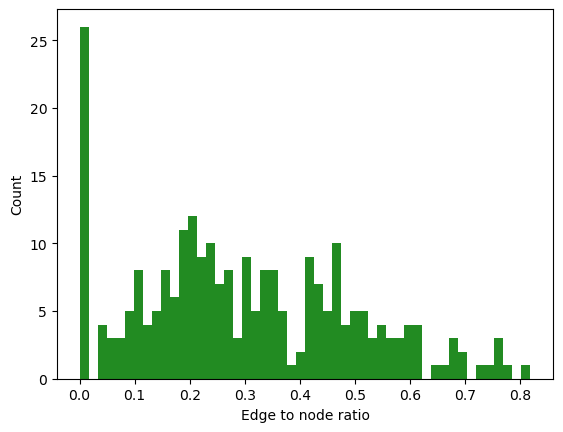

In [12]:
_ = plt.hist(per_doc_ratios.values(), bins=50, color=colors['PICKLE'])
_ = plt.xlabel('Edge to node ratio')
_ = plt.ylabel('Count')

## Evaluating available graphs
### DyGIE++

In [13]:
with jsonlines.open('../data/dygiepp/model_predictions/09Apr24_dygiepp_test_formatted_data_pickle_predictions.jsonl') as reader:
    dygiepp_preds = [obj for obj in reader]

In [14]:
dygiepp_graph = nx.read_graphml('../data/kg/dygiepp_pure_extraction_graph.graphml')

In [15]:
print(f'The DyGIE++-derived graph has {len(dygiepp_graph.nodes)} nodes and {len(dygiepp_graph.edges)} edges.')
print(f'{len(list(nx.isolates(dygiepp_graph)))} of these nodes are isolates, and the median node degree is {median([d[1] for d in dygiepp_graph.degree])}.')

The DyGIE++-derived graph has 336120 nodes and 124408 edges.
268851 of these nodes are isolates, and the median node degree is 0.0.


In [16]:
ents_per_abstract_dygiepp = defaultdict(int)
rels_per_abstract_dygiepp = defaultdict(int)
for doc in dygiepp_preds:
    entcount = 0
    relcount = 0
    for sent in doc['predicted_ner']:
        entcount += len(sent)
    for sent in doc['predicted_relations']:
        relcount += len(sent)
    ents_per_abstract_dygiepp[doc['doc_key']] = entcount
    rels_per_abstract_dygiepp[doc['doc_key']] = relcount

In [17]:
total_ratio_dygiepp = sum(rels_per_abstract_dygiepp.values())/sum(ents_per_abstract_dygiepp.values())
print(f'The DyGIE++-derived graph has a relation to entity ratio of {total_ratio_dygiepp:.2f}')

The DyGIE++-derived graph has a relation to entity ratio of 0.09


In [18]:
per_doc_ratios_dygiepp = {}
for doc in dygiepp_preds:
    try:
        per_doc_ratios_dygiepp[doc['doc_key']] = rels_per_abstract_dygiepp[doc['doc_key']]/ents_per_abstract_dygiepp[doc['doc_key']]
    except ZeroDivisionError:
        per_doc_ratios_dygiepp[doc['doc_key']] = 0

### DyGIE++ co-occurrence

In [19]:
dygiepp_co_occurrence = nx.read_graphml('../data/kg/all_drought_dt_co_occurrence_graph_02May2024.graphml')

In [20]:
print(f'The co-occurrence graph has {len(dygiepp_co_occurrence.nodes)} nodes and {len(dygiepp_co_occurrence.edges)} edges.')
print(f'{len(list(nx.isolates(dygiepp_co_occurrence)))} of these nodes are isolates, and the median node degree is {median([d[1] for d in dygiepp_co_occurrence.degree])}.')

The co-occurrence graph has 334579 nodes and 1289214 edges.
35054 of these nodes are isolates, and the median node degree is 3.


In [21]:
total_ratio_co_occurrence = len(dygiepp_co_occurrence.edges)/len(dygiepp_co_occurrence)
print(f'The co-occurrence graph has a relation to entity ratio of {total_ratio_co_occurrence:.2f}')

The co-occurrence graph has a relation to entity ratio of 3.85


To calculate the ratio on a per-document basis, we need to go back to the predictions:

In [22]:
per_doc_ratios_co_occurrence = defaultdict(int)
for doc in drought_des:
    ents = 0
    rels = 0
    for sent in doc['predicted_ner']:
        if len(sent) > 1:
            rels += comb(len(sent), 2)
        ents += len(sent)
    try:
        per_doc_ratios_co_occurrence[doc['doc_key']] = rels/ents
    except ZeroDivisionError:
        per_doc_ratios_co_occurrence[doc['doc_key']] = 0

### OpenIE

In [23]:
openie_graph = nx.read_graphml('../data/kg/openIE_filtered_graph_08May2024.graphml')

In [24]:
print(f'The OpenIE graph has {len(openie_graph.nodes)} nodes and {len(openie_graph.edges)} edges.')
print(f'{len(list(nx.isolates(openie_graph)))} of these nodes are isolates, and the median node degree is {median([d[1] for d in openie_graph.degree])}.')

The OpenIE graph has 6195 nodes and 8156 edges.
0 of these nodes are isolates, and the median node degree is 1.


In [25]:
total_ratio_openie = len(openie_graph.edges)/len(openie_graph.nodes)
print(f'The openIE graph has a relation to entity ratio of {total_ratio_openie:.2f}')

The openIE graph has a relation to entity ratio of 1.32


Read in the per-doc triples to get the per-doc ratio:

In [26]:
with open('../data/kg/openIE_per_doc_filtered_triples_21May2024.json') as f:
    filtered_openie_trips = json.load(f)

In [27]:
per_doc_ratios_openie = {}
for doc, trips in filtered_openie_trips.items():
    ents = []
    num_rels = len(trips)
    for trip in trips:
        ents.append(trip['subject'])
        ents.append(trip['object'])
    unique_ents = set(ents)
    doc_ratio = num_rels/len(unique_ents)
    per_doc_ratios_openie[doc] = doc_ratio

### OntoGPT

In [28]:
ontogpt_graph = nx.read_graphml('../data/kg/ontogpt_cleaned_graph_22May2024.graphml')

In [29]:
print(f'The OntoGPT graph has {len(ontogpt_graph.nodes)} nodes and {len(ontogpt_graph.edges)} edges.')
print(f'{len(list(nx.isolates(ontogpt_graph)))} of these nodes are isolates, and the median node degree is {median([d[1] for d in ontogpt_graph.degree])}.')

The OntoGPT graph has 12488 nodes and 3023 edges.
9981 of these nodes are isolates, and the median node degree is 0.0.


In [30]:
total_ratio_ontogpt = len(ontogpt_graph.edges)/len(ontogpt_graph.nodes)
print(f'The OntoGPT graph has a relation to entity ratio of {total_ratio_ontogpt:.2f}')

The OntoGPT graph has a relation to entity ratio of 0.24


In [31]:
onto_ents = pd.read_csv('../data/kg/ontogpt_slim_ent_df_CLEANED_20May2024.csv')
onto_rels = pd.read_csv('../data/kg/ontogpt_slim_rel_df_CLEANED_20May2024.csv')

As mentioned in the OntoGPT construction notebook, about 1100 documents didn't get any entity anntoations, which meant we had to remove them from the entity dataframe. We want to put 0's for those documents as we have been for the other model types, so we'll read in the original entity dataframe and get all the `provided_by` ID's, so we can then give them 0's.

In [32]:
orig_onto_ents = pd.read_csv('../data/kg/ontogpt_slim_ent_df_20May2024.csv')
orig_uniq_ids = orig_onto_ents.provided_by.unique().tolist()

In [33]:
all_doc_ids = set(onto_ents.provided_by.unique().tolist() + orig_uniq_ids)

In [34]:
per_doc_ratios_ontogpt = {}
div_zero = []
rels_no_ents = []
for doc in tqdm(all_doc_ids):
    num_ents = len(onto_ents[onto_ents['provided_by'] == doc])
    num_rels = len(onto_rels[onto_rels['provided_by'] == doc])
    try:
        per_doc_ratios_ontogpt[doc] = num_rels/num_ents
    except ZeroDivisionError:
        div_zero.append(doc)
        if (num_rels > 0) and (num_ents == 0):
            rels_no_ents.append(doc)
        per_doc_ratios_ontogpt[doc] = 0

100%|██████████| 5237/5237 [00:09<00:00, 577.97it/s]


In [35]:
len(div_zero)

1093

There were a few documents that had relations but no entities -- what is that about?

In [36]:
print(f'There are {len(rels_no_ents)} documents that have relations but no entities.')

There are 90 documents that have relations but no entities.


In [37]:
onto_rels[onto_rels['provided_by'].isin(rels_no_ents)].head()

,id,category,provided_by,predicate,subject,object
340,4fcbaddf-c478-41b5-805b-b42f9a9389fa,GeneProteinInteraction,82f104ba-e761-4449-9ef8-e8a12302dbbd,GeneProteinInteraction,AUTO:CDT-1,AUTO:late%20embryogenesis%20abundant%20proteins
341,203d113f-6022-48c5-8e29-f4420a7bc1f1,GeneOrganismRelationship,82f104ba-e761-4449-9ef8-e8a12302dbbd,GeneOrganismRelationship,AUTO:CDT-1,NCBITaxon:4153
342,ecc4a0ad-db74-492b-9508-828c4f40e023,ProteinOrganismRelationship,82f104ba-e761-4449-9ef8-e8a12302dbbd,ProteinOrganismRelationship,AUTO:late%20embryogenesis%20abundant%20proteins,NCBITaxon:4153
343,2cda35d5-9858-4262-b60a-3e5d6432fa0d,GeneMoleculeInteraction,82f104ba-e761-4449-9ef8-e8a12302dbbd,GeneMoleculeInteraction,AUTO:CDT-1,CHEBI:16646
344,a205bd0f-caf8-4ebc-a78d-75df1742b9b0,ProteinMoleculeInteraction,82f104ba-e761-4449-9ef8-e8a12302dbbd,ProteinMoleculeInteraction,AUTO:late%20embryogenesis%20abundant%20proteins,CHEBI:16646


I suspect this may be a symptom of the multiplied entities bug. For the moment, I'm going to leave it aside, since my assumption is that these relations would disappear if the bug were fixed, and they end up getting zeroed out anyway in this analyses; however, need to come back to this.

### Combined plots of results

In [38]:
ratio_colors = {
    'PICKLE': 'forestgreen',
    'DyGIE++': 'mediumslateblue',
    'Co-occurrence': 'hotpink',
    'OpenIE': 'lightseagreen',
    'OntoGPT': 'darkorange'
}

In [39]:
ratios = {
    'PICKLE': total_ratio,
    'DyGIE++': total_ratio_dygiepp,
    'Co-occurrence': total_ratio_co_occurrence,
    'OpenIE': total_ratio_openie,
    'OntoGPT': total_ratio_ontogpt
}

In [40]:
# From GeeksForGeeks
def addlabels(x,y):
    for i in range(len(x)):
        plt.text(i, y[i], round(y[i], 2), ha='center', va='bottom')

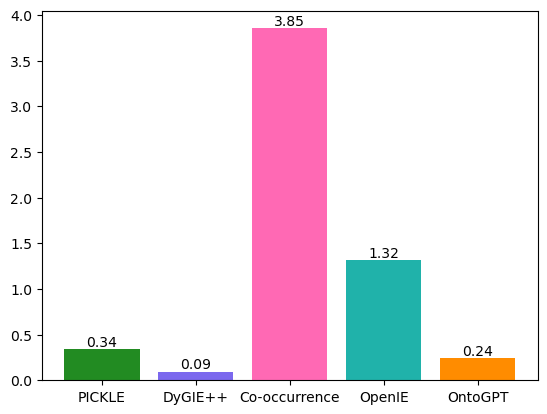

In [41]:
plt.bar(ratios.keys(), ratios.values(), color=ratio_colors.values())
addlabels(list(ratios.keys()), list(ratios.values()))

In [42]:
per_doc_ratio_dict = {
    'PICKLE': per_doc_ratios,
    'DyGIE++': per_doc_ratios_dygiepp,
    'Co-occurrence': per_doc_ratios_co_occurrence,
    'OpenIE': per_doc_ratios_openie,
    'OntoGPT': per_doc_ratios_ontogpt
}

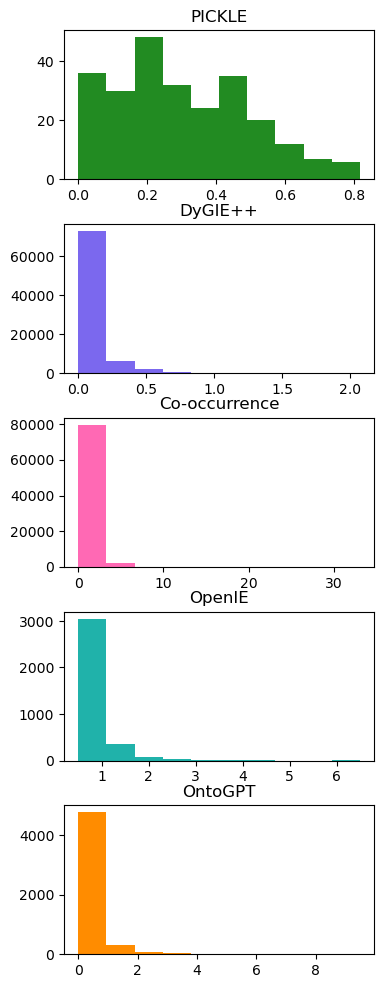

In [43]:
fig, axs = plt.subplots(5, 1, figsize=(4,12))

for ax, method in zip(axs, per_doc_ratio_dict.keys()):
    ax.hist(per_doc_ratio_dict[method].values(), color=ratio_colors[method])
    ax.set_title(method)
fig.subplots_adjust(hspace=0.3)

## NER comparisons
Our two best NER methods by observation are DyGIE++ and OntoGPT. While we don't have a gold standar to compare to, we can compare these two methods and get a sense of what their assets and drawbacks are.

The first issue is that OntoGPT auto-generates a random ID for each document rather than keeping the name of the file. Unfortunately, we found that the order is not preserved between the order the files appear in the input directory and the order in which they are provessed by OntoGPT, so we're going to have to match the documents to their plain text equivalents. Because of the multiplied entities bug, it takes ages to read the YAML file (it slows down as it progresses due to the proliferation of entities), so we'll make a script for it and run it on the command line and read it in here. 

In [44]:
with open('../data/ontogpt_output/destol_onto_id_to_dygiepp_doc_key_23May2024.json') as f:
    onto_id2doc_key = json.load(f)

Check that this mapping worked:

In [48]:
dygiepp_by_doc_key = {d['doc_key']: d for d in dygiepp_preds}

In [49]:
doc_key2onto_id = {v: k for k, v in onto_id2doc_key.items()}
assert len(onto_id2doc_key) == len(doc_key2onto_id) 

In [50]:
for i in range(10):
    doc_key = list(doc_key2onto_id.keys())[i]
    doc_sents = [tok for sent in dygiepp_by_doc_key[doc_key]['sentences'] for tok in sent]
    dygiepp_single_doc_ents = []
    for sent in dygiepp_by_doc_key[doc_key]['predicted_ner']:
        for ent in sent:
            ent_text = ' '.join(doc_sents[ent[0]: ent[1]+1])
            dygiepp_single_doc_ents.append(ent_text)
    ontogpt_single_doc_ents = onto_ents[onto_ents['provided_by'] == doc_key2onto_id[doc_key]].name.tolist()
    print(f'\n{doc_key} abstract:')
    print('----------------------------------------')
    print(' '.join(doc_sents))
    print('-------------------------------------------')
    print(f'DyGIE++ entities: {dygiepp_single_doc_ents}')
    print(f'OntoGPT entities for presumed same document: {ontogpt_single_doc_ents}')
    print('-----------------------------------------------\n\n')


WOS:000292609500003 abstract:
----------------------------------------
Differential drying rates of recalcitrant Trichilia dregeana embryonic axes : a study of survival and oxidative stress metabolism | Studies to elucidate the biochemical basis of survival of excised embryonic axes ( EAs ) of recalcitrant seeds of Trichilia dregeana at different drying rates revealed significant differences between slow and rapid drying . Rapid drying allowed these EAs to survive dehydration to much lower water contents ( WCs ; ca . 0.31 g g(-1 ) dry mass basis with 73 % germination ) compared with slow drying , where 90 % of the EAs lost viability at a WC of ca . 0.79 g g(-1 ) . In EAs slowly dried within seeds , the levels of hydroxyl radical ( three- to fivefold at WCs > 0.5 g g(-1 ) ) and lipid peroxidation ( 50 % at similar WC ) were significantly higher compared with those dried rapidly to comparable WCs . When EAs were dried slowly , enzymic antioxidant levels were not sustained and declined s

As we can see from these five sample documents, DyGIE++ extracts every mention of each entity, while OntoGPT functions at a per-document level. However, OntoGPT does not successfully extract every doc-level mention of relevant entities, and therfore misses a lot of content compared to DyGIE++.

One way to semi-quantify what's happening is to check how many unique entities each method is identifying, as DyGIE++ extracts many duplicates.

In [52]:
onto_dyg_comparison = defaultdict(dict)
for doc_key, onto_id in doc_key2onto_id.items(): 
    doc_sents = [tok for sent in dygiepp_by_doc_key[doc_key]['sentences'] for tok in sent]
    dygiepp_single_doc_ents = []
    for sent in dygiepp_by_doc_key[doc_key]['predicted_ner']:
        for ent in sent:
            ent_text = ' '.join(doc_sents[ent[0]: ent[1]+1])
            dygiepp_single_doc_ents.append(ent_text)
    unique_dygiepp_ents = set([e.lower() for e in dygiepp_single_doc_ents])
    ontogpt_single_doc_ents = set([str(e).lower() for e in onto_ents[onto_ents['provided_by'] == doc_key2onto_id[doc_key]].name.tolist()])
    shared_ents = unique_dygiepp_ents.intersection(ontogpt_single_doc_ents)
    onto_dyg_comparison[doc_key]['dygiepp_ents'] = unique_dygiepp_ents
    onto_dyg_comparison[doc_key]['ontogpt_ents'] = ontogpt_single_doc_ents
    onto_dyg_comparison[doc_key]['shared'] = shared_ents

Quantify the proportions shared and separate for all docs:

In [56]:
frac_dygiepp_shared = []
frac_ontogpt_shared = []
for doc, ent_comp in onto_dyg_comparison.items():
    if len(ent_comp['shared']) > 0:
        frac_dygiepp_shared.append(len(ent_comp['shared'])/len(ent_comp['dygiepp_ents']))
        frac_ontogpt_shared.append(len(ent_comp['shared'])/len(ent_comp['ontogpt_ents']))

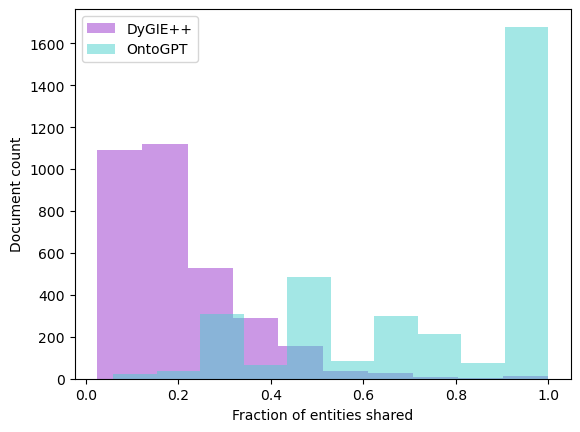

In [64]:
fig, ax = plt.subplots()

ax.hist(frac_dygiepp_shared, color='darkorchid', alpha=0.5, label='DyGIE++')
ax.hist(frac_ontogpt_shared, color='mediumturquoise', alpha=0.5, label='OntoGPT')
ax.set_xlabel('Fraction of entities shared')
ax.set_ylabel('Document count')
ax.legend()

Let's use displaCy to visualize the DyGIE++ entities for a few of these abstracts, so we can make a figure comparing them to the OntoGPT entities. 

In [ ]:
nlp = spacy.load("en_core_sci_sm") # Should give the same tokenization as DyGIE++ has
dirname = '../data/ontogpt_input/destol_final/'
docfiles = list(listdir(dirname))
docs_with_ents = {}
for i in tqdm(range(5)):
    fname = docfiles[i]
    doc_key = splitext(fname)[0]
    with open(f'{dirname}/{fname}') as f:
        text = f.read()
    doc = nlp(text)
    doc_ents = []
    for sent in dygiepp_by_doc_key[doc_key]['predicted_ner']:
        for ent in sent:
            span = doc[ent[0]: ent[1]+1]
            doc_ents.append(span)
    doc.set_ents(entities=doc_ents)
    docs_with_ents[doc_key] = doc

What about relations?